# Memory Requirements Estimation Analysis
## Estimating keysMaximum, bridgesAtMaximum, and bit_length as functions of n

This notebook analyzes the computational data from `estimatingMemoryNeeds.txt` to create mathematical estimates for memory requirements in the mapFolding algorithm.

## 1. Import Required Libraries
Import necessary libraries including pandas, numpy, matplotlib, seaborn, and sklearn for data analysis and modeling.

In [ ]:
# Install required packages
%pip install matplotlib seaborn scikit-learn scipy scipy-stubs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from scipy import optimize
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully")

## 2. Load and Parse the Data
Parse the text file data to extract n, keysMaximum, bridgesAtMaximum, and bit_length values into a structured DataFrame.

In [2]:
# Read the data file
file_path = r'c:\apps\mapFolding\mapFolding\_oeisFormulas\estimatingMemoryNeeds.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()

# Parse the data
data_records = []

# First record (n=4) has detailed format
first_line = lines[1]  # Skip the header comment
parts = first_line.strip().split(', ')
keys_max = int(parts[0].split('=')[1])
bridges_at_max = int(parts[1].split('=')[1])
bit_length = int(parts[2].split('=')[1])

# Extract n from the following line which has the format "Valid computation = True n=4 a(n)=16 computation time in seconds=0.00"
validation_line = lines[2].strip()
n_part = validation_line.split()[4]  # Get "n=4"
n_value = int(n_part.split('=')[1])  # Extract 4
data_records.append({'n': n_value, 'keysMaximum': keys_max, 'bridgesAtMaximum': bridges_at_max, 'bitLength': bit_length})

# Parse remaining records
# The pattern is: number line, keysMaximum line, "True n value ..." line
i = 4  # Start after the first record
while i < len(lines):
    # Skip empty lines
    while i < len(lines) and lines[i].strip() == '':
        i += 1

    if i >= len(lines):
        break

    # Check if this is a number line (starts with a digit)
    if lines[i].strip().isdigit():
        # Next line should be the keysMaximum line
        if i + 1 < len(lines) and lines[i + 1].strip().startswith('keysMaximum='):
            line = lines[i + 1].strip()
            parts = line.split(', ')
            keys_max = int(parts[0].split('=')[1])
            bridges_at_max = int(parts[1].split('=')[1])
            bit_length = int(parts[2].split('=')[1])

            # Next line should have the n value in format "True n value ..."
            if i + 2 < len(lines):
                validation_line = lines[i + 2].strip()
                if validation_line.startswith('True'):
                    validation_parts = validation_line.split()
                    n_value = int(validation_parts[1])  # n is the second value after "True"

                    data_records.append({'n': n_value, 'keysMaximum': keys_max, 'bridgesAtMaximum': bridges_at_max, 'bitLength': bit_length})

        i += 3  # Move to next record
    else:
        i += 1

# Create DataFrame
dataFrame = pd.DataFrame(data_records)
dataFrame = dataFrame.sort_values('n').reset_index(drop=True)

print(f"Successfully parsed {len(dataFrame)} records")
print("\nFirst few records:")
print(dataFrame.head())
print("\nLast few records:")
print(dataFrame.tail())
print("\nDataFrame info:")
print(dataFrame.info())

Successfully parsed 37 records

First few records:
   n  keysMaximum  bridgesAtMaximum  bitLength
0  4            4                 2          9
1  5            6                 2          9
2  6           10                 3         11
3  7           16                 3         11
4  8           21                 3         11

Last few records:
     n  keysMaximum  bridgesAtMaximum  bitLength
32  36      6413539                15         35
33  37     10469002                15         35
34  38     16003046                15         35
35  39     26617330                16         37
36  40     41771189                16         37

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   n                 37 non-null     int64
 1   keysMaximum       37 non-null     int64
 2   bridgesAtMaximum  37 non-null     int64
 3   bitLe

## 3. Data Exploration and Visualization
Create scatter plots and examine the relationships between variables. Visualize how keysMaximum, bridgesAtMaximum, and bit_length change with respect to n.

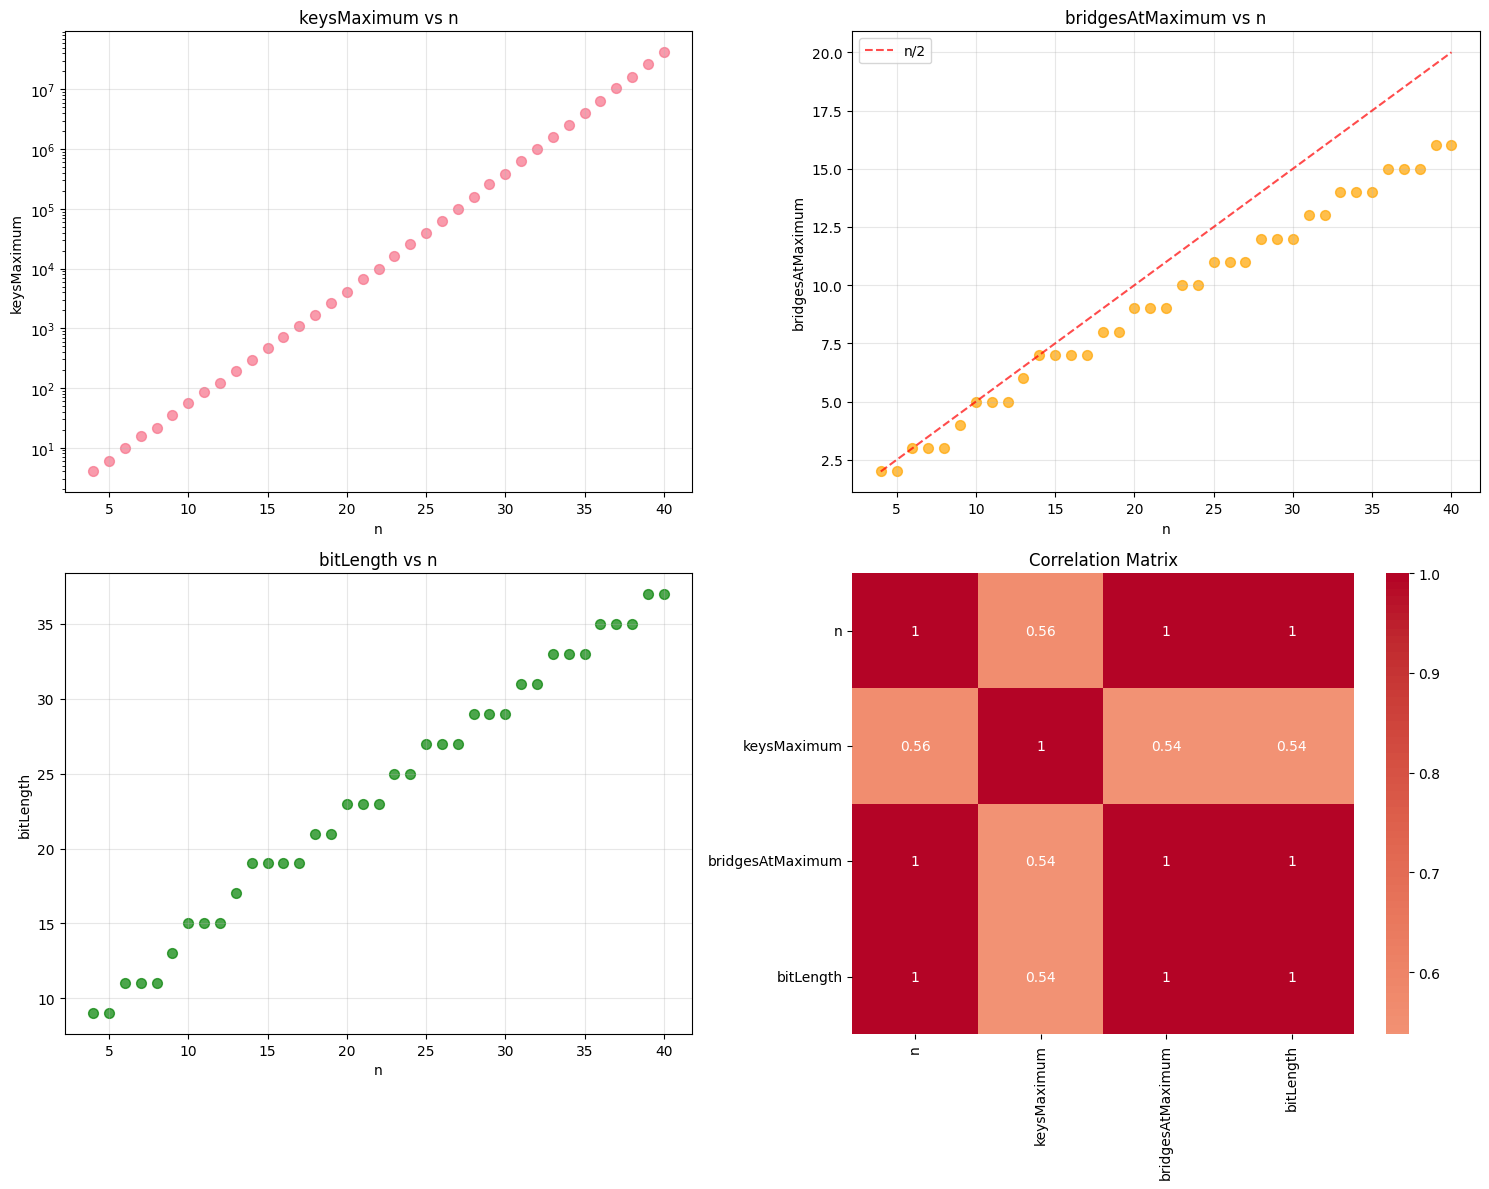

Summary Statistics:
               n   keysMaximum  bridgesAtMaximum  bitLength
count  37.000000  3.700000e+01         37.000000  37.000000
mean   22.000000  3.032335e+06          9.270270  23.540541
std    10.824355  8.411565e+06          4.272968   8.545937
min     4.000000  4.000000e+00          2.000000   9.000000
25%    13.000000  1.940000e+02          6.000000  17.000000
50%    22.000000  9.997000e+03          9.000000  23.000000
75%    31.000000  6.417660e+05         13.000000  31.000000
max    40.000000  4.177119e+07         16.000000  37.000000


In [3]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: keysMaximum vs n
axes[0, 0].scatter(dataFrame['n'], dataFrame['keysMaximum'], alpha=0.7, s=50)
axes[0, 0].set_xlabel('n')
axes[0, 0].set_ylabel('keysMaximum')
axes[0, 0].set_title('keysMaximum vs n')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Plot 2: bridgesAtMaximum vs n
axes[0, 1].scatter(dataFrame['n'], dataFrame['bridgesAtMaximum'], alpha=0.7, s=50, color='orange')
# Add n/2 line for reference
n_range = np.linspace(dataFrame['n'].min(), dataFrame['n'].max(), 100)
axes[0, 1].plot(n_range, n_range/2, 'r--', alpha=0.7, label='n/2')
axes[0, 1].set_xlabel('n')
axes[0, 1].set_ylabel('bridgesAtMaximum')
axes[0, 1].set_title('bridgesAtMaximum vs n')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Plot 3: bitLength vs n
axes[1, 0].scatter(dataFrame['n'], dataFrame['bitLength'], alpha=0.7, s=50, color='green')
axes[1, 0].set_xlabel('n')
axes[1, 0].set_ylabel('bitLength')
axes[1, 0].set_title('bitLength vs n')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Correlation matrix
correlation_matrix = dataFrame[['n', 'keysMaximum', 'bridgesAtMaximum', 'bitLength']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 1])
axes[1, 1].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

# Summary statistics
print("Summary Statistics:")
print(dataFrame.describe())

## 4. Estimate keysMaximum as a Function of n
Fit polynomial and exponential models to estimate keysMaximum as a function of n. Compare different regression approaches and evaluate model performance.

Polynomial degree 2: R² = 0.628451, RMSE = 5057495
Polynomial degree 3: R² = 0.841116, RMSE = 3307255
Polynomial degree 4: R² = 0.945625, RMSE = 1934760
Polynomial degree 5: R² = 0.984933, RMSE = 1018468

Exponential model: R² = 0.999852, RMSE = 100911
Exponential parameters: a = 0.319300, b = 1.595669

Power law model: R² = 0.999682, RMSE = 148007
Power law parameters: a = 0.000000, b = 17.858963


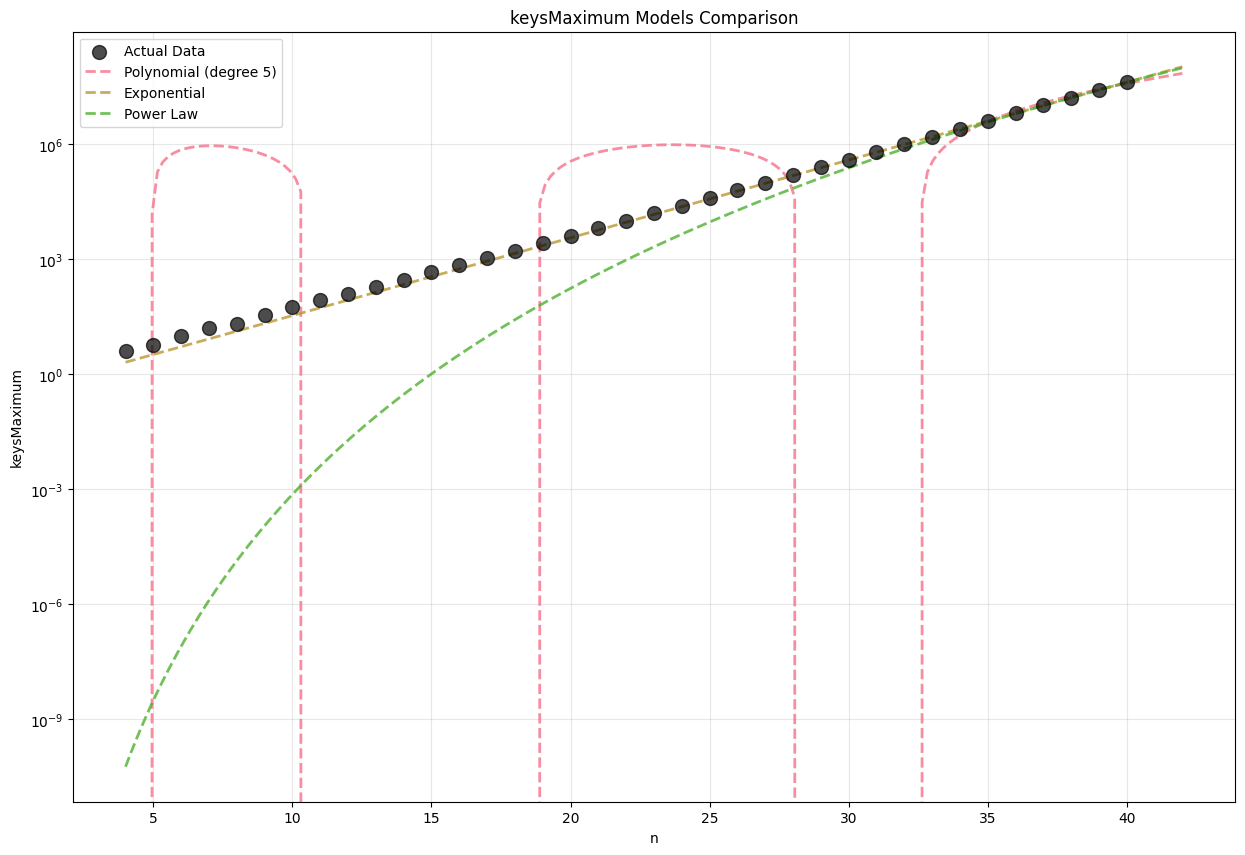


=== Best Model for keysMaximum ===
Best model: Exponential
R² = 0.999852


In [4]:
# Prepare data for keysMaximum modeling
x_values = dataFrame['n'].values.reshape(-1, 1)
y_keys = dataFrame['keysMaximum'].values

# Model 1: Polynomial regression (degree 2, 3, 4)
polynomial_models = {}
polynomial_scores = {}

for degree in [2, 3, 4, 5]:
    poly_model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression())
    ])
    poly_model.fit(x_values, y_keys)
    y_pred = poly_model.predict(x_values)
    r2 = r2_score(y_keys, y_pred)
    rmse = np.sqrt(mean_squared_error(y_keys, y_pred))

    polynomial_models[degree] = poly_model
    polynomial_scores[degree] = {'r2': r2, 'rmse': rmse}
    print(f"Polynomial degree {degree}: R² = {r2:.6f}, RMSE = {rmse:.0f}")

# Model 2: Exponential fit (a * b^n)
def exponential_function(n, a, b):
    return a * (b ** n)

try:
    popt_exp, _ = optimize.curve_fit(exponential_function, dataFrame['n'], y_keys,
                                   p0=[1, 1.5], maxfev=10000)
    y_exp_pred = exponential_function(dataFrame['n'], *popt_exp)
    r2_exp = r2_score(y_keys, y_exp_pred)
    rmse_exp = np.sqrt(mean_squared_error(y_keys, y_exp_pred))
    print(f"\nExponential model: R² = {r2_exp:.6f}, RMSE = {rmse_exp:.0f}")
    print(f"Exponential parameters: a = {popt_exp[0]:.6f}, b = {popt_exp[1]:.6f}")
except:
    print("\nExponential fit failed")
    popt_exp = None

# Model 3: Power law fit (a * n^b)
def power_function(n, a, b):
    return a * (n ** b)

try:
    popt_power, _ = optimize.curve_fit(power_function, dataFrame['n'], y_keys,
                                     p0=[1, 2], maxfev=10000)
    y_power_pred = power_function(dataFrame['n'], *popt_power)
    r2_power = r2_score(y_keys, y_power_pred)
    rmse_power = np.sqrt(mean_squared_error(y_keys, y_power_pred))
    print(f"\nPower law model: R² = {r2_power:.6f}, RMSE = {rmse_power:.0f}")
    print(f"Power law parameters: a = {popt_power[0]:.6f}, b = {popt_power[1]:.6f}")
except:
    print("\nPower law fit failed")
    popt_power = None

# Visualization of keysMaximum models
plt.figure(figsize=(15, 10))

# Plot data
plt.scatter(dataFrame['n'], y_keys, alpha=0.7, s=100, label='Actual Data', color='black', zorder=5)

# Plot predictions
n_range = np.linspace(4, 42, 200)

# Best polynomial model
best_poly_degree = max(polynomial_scores.keys(), key=lambda k: polynomial_scores[k]['r2'])
best_poly_model = polynomial_models[best_poly_degree]
y_poly_range = best_poly_model.predict(n_range.reshape(-1, 1))
plt.plot(n_range, y_poly_range, '--', linewidth=2,
         label=f'Polynomial (degree {best_poly_degree})', alpha=0.8)

# Exponential model
if popt_exp is not None:
    y_exp_range = exponential_function(n_range, *popt_exp)
    plt.plot(n_range, y_exp_range, '--', linewidth=2,
             label='Exponential', alpha=0.8)

# Power law model
if popt_power is not None:
    y_power_range = power_function(n_range, *popt_power)
    plt.plot(n_range, y_power_range, '--', linewidth=2,
             label='Power Law', alpha=0.8)

plt.xlabel('n')
plt.ylabel('keysMaximum')
plt.title('keysMaximum Models Comparison')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Select best model for keysMaximum
print("\n=== Best Model for keysMaximum ===")
best_r2 = max(polynomial_scores[best_poly_degree]['r2'],
              r2_exp if popt_exp is not None else 0,
              r2_power if popt_power is not None else 0)

if polynomial_scores[best_poly_degree]['r2'] == best_r2:
    print(f"Best model: Polynomial degree {best_poly_degree}")
    print(f"R² = {polynomial_scores[best_poly_degree]['r2']:.6f}")
    keysMaximum_best_model = best_poly_model
    keysMaximum_model_type = 'polynomial'
elif popt_exp is not None and r2_exp == best_r2:
    print(f"Best model: Exponential")
    print(f"R² = {r2_exp:.6f}")
    keysMaximum_best_model = lambda n: exponential_function(n, *popt_exp)
    keysMaximum_model_type = 'exponential'
else:
    print(f"Best model: Power Law")
    print(f"R² = {r2_power:.6f}")
    keysMaximum_best_model = lambda n: power_function(n, *popt_power)
    keysMaximum_model_type = 'power'

## 5. Estimate bridgesAtMaximum as a Function of n
Analyze the relationship between bridgesAtMaximum and n, fitting linear and polynomial models to capture the n/2 relationship pattern.

Linear model: R² = 0.992714, RMSE = 0.360
Linear equation: bridgesAtMaximum = 0.393314 * n + 0.617354

n/2 + constant model: R² = 0.919675, RMSE = 1.195
Equation: bridgesAtMaximum = n/2 + -1.729730

Polynomial degree 2: R² = 0.994214, RMSE = 0.321

Polynomial degree 3: R² = 0.994338, RMSE = 0.317


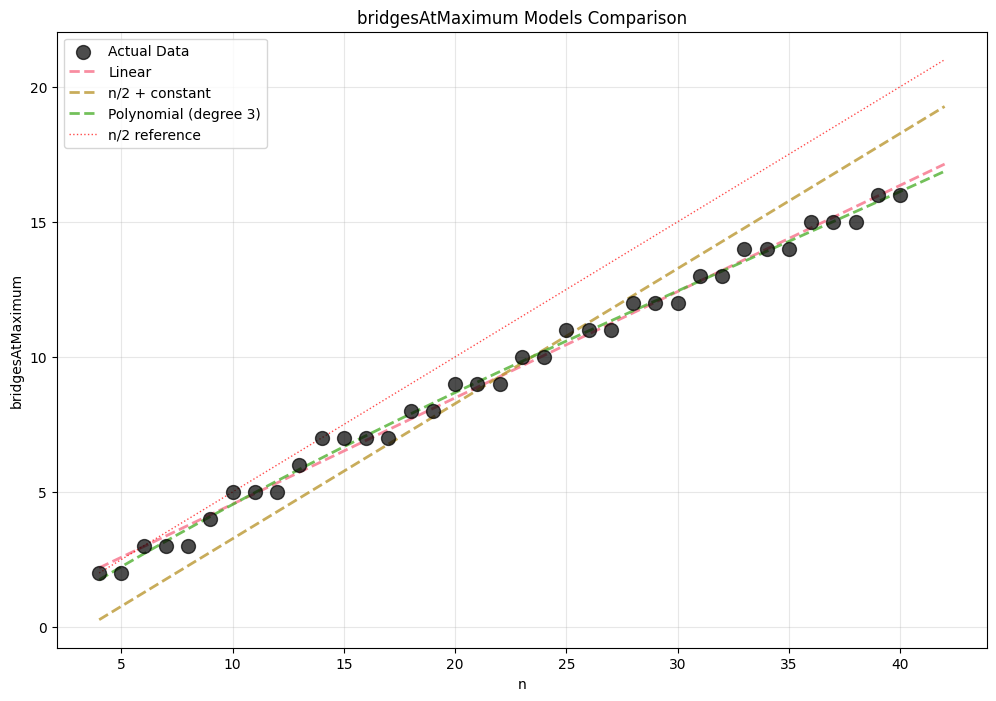


=== Best Model for bridgesAtMaximum ===
Best model: Polynomial degree 3
R² = 0.994338


In [5]:
# Prepare data for bridgesAtMaximum modeling
y_bridges = dataFrame['bridgesAtMaximum'].values

# Model 1: Linear regression
linear_model = LinearRegression()
linear_model.fit(x_values, y_bridges)
y_linear_pred = linear_model.predict(x_values)
r2_linear = r2_score(y_bridges, y_linear_pred)
rmse_linear = np.sqrt(mean_squared_error(y_bridges, y_linear_pred))

print(f"Linear model: R² = {r2_linear:.6f}, RMSE = {rmse_linear:.3f}")
print(f"Linear equation: bridgesAtMaximum = {linear_model.coef_[0]:.6f} * n + {linear_model.intercept_:.6f}")

# Model 2: Force n/2 relationship
# Calculate residuals from n/2
half_n_values = dataFrame['n'] / 2
residuals_half_n = y_bridges - half_n_values
mean_residual = np.mean(residuals_half_n)
r2_half_n = r2_score(y_bridges, half_n_values + mean_residual)
rmse_half_n = np.sqrt(mean_squared_error(y_bridges, half_n_values + mean_residual))

print(f"\nn/2 + constant model: R² = {r2_half_n:.6f}, RMSE = {rmse_half_n:.3f}")
print(f"Equation: bridgesAtMaximum = n/2 + {mean_residual:.6f}")

# Model 3: Polynomial models
bridges_poly_models = {}
bridges_poly_scores = {}

for degree in [2, 3]:
    poly_model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression())
    ])
    poly_model.fit(x_values, y_bridges)
    y_pred = poly_model.predict(x_values)
    r2 = r2_score(y_bridges, y_pred)
    rmse = np.sqrt(mean_squared_error(y_bridges, y_pred))

    bridges_poly_models[degree] = poly_model
    bridges_poly_scores[degree] = {'r2': r2, 'rmse': rmse}
    print(f"\nPolynomial degree {degree}: R² = {r2:.6f}, RMSE = {rmse:.3f}")

# Visualization of bridgesAtMaximum models
plt.figure(figsize=(12, 8))

# Plot data
plt.scatter(dataFrame['n'], y_bridges, alpha=0.7, s=100, label='Actual Data', color='black', zorder=5)

# Plot predictions
n_range = np.linspace(4, 42, 200)

# Linear model
y_linear_range = linear_model.predict(n_range.reshape(-1, 1))
plt.plot(n_range, y_linear_range, '--', linewidth=2, label='Linear', alpha=0.8)

# n/2 + constant model
y_half_n_range = n_range / 2 + mean_residual
plt.plot(n_range, y_half_n_range, '--', linewidth=2, label='n/2 + constant', alpha=0.8)

# Best polynomial model
best_bridges_poly_degree = max(bridges_poly_scores.keys(), key=lambda k: bridges_poly_scores[k]['r2'])
best_bridges_poly_model = bridges_poly_models[best_bridges_poly_degree]
y_bridges_poly_range = best_bridges_poly_model.predict(n_range.reshape(-1, 1))
plt.plot(n_range, y_bridges_poly_range, '--', linewidth=2,
         label=f'Polynomial (degree {best_bridges_poly_degree})', alpha=0.8)

# Reference n/2 line
plt.plot(n_range, n_range/2, 'r:', linewidth=1, label='n/2 reference', alpha=0.7)

plt.xlabel('n')
plt.ylabel('bridgesAtMaximum')
plt.title('bridgesAtMaximum Models Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Select best model for bridgesAtMaximum
print("\n=== Best Model for bridgesAtMaximum ===")
all_bridges_r2 = [r2_linear, r2_half_n] + [bridges_poly_scores[k]['r2'] for k in bridges_poly_scores]
best_bridges_r2 = max(all_bridges_r2)

if r2_linear == best_bridges_r2:
    print(f"Best model: Linear")
    print(f"R² = {r2_linear:.6f}")
    bridgesAtMaximum_best_model = linear_model
    bridgesAtMaximum_model_type = 'linear'
elif r2_half_n == best_bridges_r2:
    print(f"Best model: n/2 + constant")
    print(f"R² = {r2_half_n:.6f}")
    bridgesAtMaximum_best_model = lambda n: n/2 + mean_residual
    bridgesAtMaximum_model_type = 'half_n'
else:
    print(f"Best model: Polynomial degree {best_bridges_poly_degree}")
    print(f"R² = {bridges_poly_scores[best_bridges_poly_degree]['r2']:.6f}")
    bridgesAtMaximum_best_model = best_bridges_poly_model
    bridgesAtMaximum_model_type = 'polynomial'

## 6. Estimate Bit Length as a Function of n
Model the bit_length as a function of n using logarithmic and polynomial regression to capture the growth pattern of the maximum key sizes.

Linear model: R² = 0.992714, RMSE = 0.720
Linear equation: bitLength = 0.786629 * n + 6.234708

Logarithmic model: R² = 0.935348, RMSE = 2.143
Logarithmic equation: bitLength = 13.258273 * log(n) + -15.348797

Polynomial degree 2: R² = 0.994214, RMSE = 0.641

Polynomial degree 3: R² = 0.994338, RMSE = 0.634

Log2 model: R² = 0.935348, RMSE = 2.143
Log2 equation: bitLength = 9.189934 * log2(n) + -15.348797


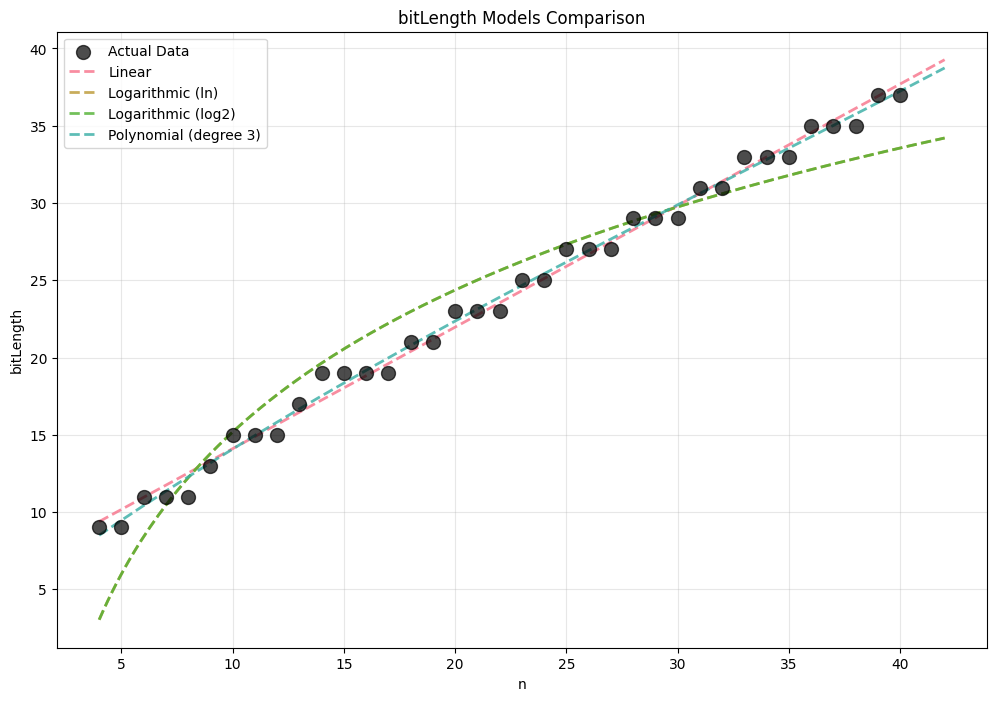


=== Best Model for bitLength ===
Best model: Polynomial degree 3
R² = 0.994338


In [6]:
# Prepare data for bitLength modeling
y_bits = dataFrame['bitLength'].values

# Model 1: Linear regression
linear_bits_model = LinearRegression()
linear_bits_model.fit(x_values, y_bits)
y_linear_bits_pred = linear_bits_model.predict(x_values)
r2_linear_bits = r2_score(y_bits, y_linear_bits_pred)
rmse_linear_bits = np.sqrt(mean_squared_error(y_bits, y_linear_bits_pred))

print(f"Linear model: R² = {r2_linear_bits:.6f}, RMSE = {rmse_linear_bits:.3f}")
print(f"Linear equation: bitLength = {linear_bits_model.coef_[0]:.6f} * n + {linear_bits_model.intercept_:.6f}")

# Model 2: Logarithmic relationship (a * log(n) + b)
log_n_values = np.log(dataFrame['n']).values.reshape(-1, 1)
log_bits_model = LinearRegression()
log_bits_model.fit(log_n_values, y_bits)
y_log_bits_pred = log_bits_model.predict(log_n_values)
r2_log_bits = r2_score(y_bits, y_log_bits_pred)
rmse_log_bits = np.sqrt(mean_squared_error(y_bits, y_log_bits_pred))

print(f"\nLogarithmic model: R² = {r2_log_bits:.6f}, RMSE = {rmse_log_bits:.3f}")
print(f"Logarithmic equation: bitLength = {log_bits_model.coef_[0]:.6f} * log(n) + {log_bits_model.intercept_:.6f}")

# Model 3: Polynomial models
bits_poly_models = {}
bits_poly_scores = {}

for degree in [2, 3]:
    poly_model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression())
    ])
    poly_model.fit(x_values, y_bits)
    y_pred = poly_model.predict(x_values)
    r2 = r2_score(y_bits, y_pred)
    rmse = np.sqrt(mean_squared_error(y_bits, y_pred))

    bits_poly_models[degree] = poly_model
    bits_poly_scores[degree] = {'r2': r2, 'rmse': rmse}
    print(f"\nPolynomial degree {degree}: R² = {r2:.6f}, RMSE = {rmse:.3f}")

# Model 4: Logarithmic base 2 (related to bit growth)
log2_n_values = np.log2(dataFrame['n']).values.reshape(-1, 1)
log2_bits_model = LinearRegression()
log2_bits_model.fit(log2_n_values, y_bits)
y_log2_bits_pred = log2_bits_model.predict(log2_n_values)
r2_log2_bits = r2_score(y_bits, y_log2_bits_pred)
rmse_log2_bits = np.sqrt(mean_squared_error(y_bits, y_log2_bits_pred))

print(f"\nLog2 model: R² = {r2_log2_bits:.6f}, RMSE = {rmse_log2_bits:.3f}")
print(f"Log2 equation: bitLength = {log2_bits_model.coef_[0]:.6f} * log2(n) + {log2_bits_model.intercept_:.6f}")

# Visualization of bitLength models
plt.figure(figsize=(12, 8))

# Plot data
plt.scatter(dataFrame['n'], y_bits, alpha=0.7, s=100, label='Actual Data', color='black', zorder=5)

# Plot predictions
n_range = np.linspace(4, 42, 200)

# Linear model
y_linear_bits_range = linear_bits_model.predict(n_range.reshape(-1, 1))
plt.plot(n_range, y_linear_bits_range, '--', linewidth=2, label='Linear', alpha=0.8)

# Logarithmic model
y_log_bits_range = log_bits_model.predict(np.log(n_range).reshape(-1, 1))
plt.plot(n_range, y_log_bits_range, '--', linewidth=2, label='Logarithmic (ln)', alpha=0.8)

# Log2 model
y_log2_bits_range = log2_bits_model.predict(np.log2(n_range).reshape(-1, 1))
plt.plot(n_range, y_log2_bits_range, '--', linewidth=2, label='Logarithmic (log2)', alpha=0.8)

# Best polynomial model
best_bits_poly_degree = max(bits_poly_scores.keys(), key=lambda k: bits_poly_scores[k]['r2'])
best_bits_poly_model = bits_poly_models[best_bits_poly_degree]
y_bits_poly_range = best_bits_poly_model.predict(n_range.reshape(-1, 1))
plt.plot(n_range, y_bits_poly_range, '--', linewidth=2,
         label=f'Polynomial (degree {best_bits_poly_degree})', alpha=0.8)

plt.xlabel('n')
plt.ylabel('bitLength')
plt.title('bitLength Models Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Select best model for bitLength
print("\n=== Best Model for bitLength ===")
all_bits_r2 = [r2_linear_bits, r2_log_bits, r2_log2_bits] + [bits_poly_scores[k]['r2'] for k in bits_poly_scores]
best_bits_r2 = max(all_bits_r2)

if r2_linear_bits == best_bits_r2:
    print(f"Best model: Linear")
    print(f"R² = {r2_linear_bits:.6f}")
    bitLength_best_model = linear_bits_model
    bitLength_model_type = 'linear'
elif r2_log_bits == best_bits_r2:
    print(f"Best model: Logarithmic (natural log)")
    print(f"R² = {r2_log_bits:.6f}")
    bitLength_best_model = lambda n: log_bits_model.predict(np.log(np.array([n])).reshape(-1, 1))[0]
    bitLength_model_type = 'log'
elif r2_log2_bits == best_bits_r2:
    print(f"Best model: Logarithmic (log2)")
    print(f"R² = {r2_log2_bits:.6f}")
    bitLength_best_model = lambda n: log2_bits_model.predict(np.log2(np.array([n])).reshape(-1, 1))[0]
    bitLength_model_type = 'log2'
else:
    print(f"Best model: Polynomial degree {best_bits_poly_degree}")
    print(f"R² = {bits_poly_scores[best_bits_poly_degree]['r2']:.6f}")
    bitLength_best_model = best_bits_poly_model
    bitLength_model_type = 'polynomial'

## 7. Model Validation and Comparison
Evaluate model accuracy using metrics like R-squared and RMSE. Compare predictions with actual values and select the best fitting models.

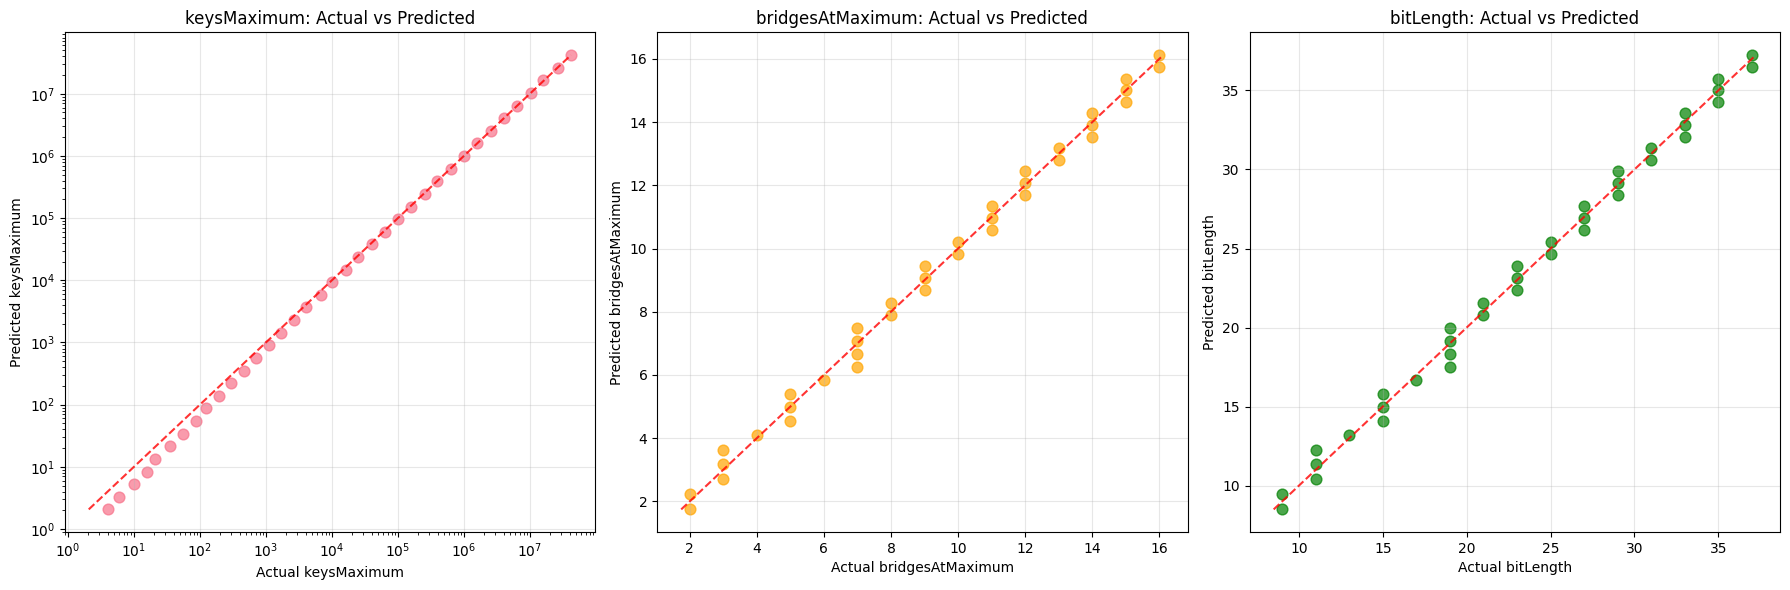

=== Final Model Performance ===
keysMaximum - R²: 0.999852, RMSE: 100911
bridgesAtMaximum - R²: 0.994338, RMSE: 0.317
bitLength - R²: 0.994338, RMSE: 0.634

=== Sample Predictions ===
    n  keysMaximum  keysMaximum_predicted  keys_error_percent  \
0   4            4               2.069997           48.250079   
1   5            6               3.303029           44.949515   
2   6           10               5.270540           47.294599   
3   7           16               8.410036           47.437276   
4   8           21              13.419631           36.096997   
5   9           35              21.413284           38.819187   
6  10           56              34.168507           38.984808   
7  11           86              54.521617           36.602771   
8  12          123              86.998437           29.269563   
9  13          194             138.820682           28.442948   

   bridgesAtMaximum  bridgesAtMaximum_predicted  bridges_error_percent  \
0                 2       

In [7]:
# Create comprehensive validation plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Function to make predictions with best models
def predict_keysMaximum(n_val):
    if keysMaximum_model_type == 'polynomial':
        return keysMaximum_best_model.predict(np.array([[n_val]]))[0]
    else:
        return keysMaximum_best_model(n_val)

def predict_bridgesAtMaximum(n_val):
    if bridgesAtMaximum_model_type == 'linear':
        return bridgesAtMaximum_best_model.predict(np.array([[n_val]]))[0]
    elif bridgesAtMaximum_model_type == 'polynomial':
        return bridgesAtMaximum_best_model.predict(np.array([[n_val]]))[0]
    else:
        return bridgesAtMaximum_best_model(n_val)

def predict_bitLength(n_val):
    if bitLength_model_type in ['linear', 'polynomial']:
        return bitLength_best_model.predict(np.array([[n_val]]))[0]
    else:
        return bitLength_best_model(n_val)

# Generate predictions for all data points
predictions_keys = [predict_keysMaximum(n) for n in dataFrame['n']]
predictions_bridges = [predict_bridgesAtMaximum(n) for n in dataFrame['n']]
predictions_bits = [predict_bitLength(n) for n in dataFrame['n']]

# Plot 1: keysMaximum - Actual vs Predicted
axes[0].scatter(dataFrame['keysMaximum'], predictions_keys, alpha=0.7, s=60)
min_val = min(min(dataFrame['keysMaximum']), min(predictions_keys))
max_val = max(max(dataFrame['keysMaximum']), max(predictions_keys))
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
axes[0].set_xlabel('Actual keysMaximum')
axes[0].set_ylabel('Predicted keysMaximum')
axes[0].set_title('keysMaximum: Actual vs Predicted')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Plot 2: bridgesAtMaximum - Actual vs Predicted
axes[1].scatter(dataFrame['bridgesAtMaximum'], predictions_bridges, alpha=0.7, s=60, color='orange')
min_val = min(min(dataFrame['bridgesAtMaximum']), min(predictions_bridges))
max_val = max(max(dataFrame['bridgesAtMaximum']), max(predictions_bridges))
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
axes[1].set_xlabel('Actual bridgesAtMaximum')
axes[1].set_ylabel('Predicted bridgesAtMaximum')
axes[1].set_title('bridgesAtMaximum: Actual vs Predicted')
axes[1].grid(True, alpha=0.3)

# Plot 3: bitLength - Actual vs Predicted
axes[2].scatter(dataFrame['bitLength'], predictions_bits, alpha=0.7, s=60, color='green')
min_val = min(min(dataFrame['bitLength']), min(predictions_bits))
max_val = max(max(dataFrame['bitLength']), max(predictions_bits))
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
axes[2].set_xlabel('Actual bitLength')
axes[2].set_ylabel('Predicted bitLength')
axes[2].set_title('bitLength: Actual vs Predicted')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate final metrics
r2_keys_final = r2_score(dataFrame['keysMaximum'], predictions_keys)
rmse_keys_final = np.sqrt(mean_squared_error(dataFrame['keysMaximum'], predictions_keys))

r2_bridges_final = r2_score(dataFrame['bridgesAtMaximum'], predictions_bridges)
rmse_bridges_final = np.sqrt(mean_squared_error(dataFrame['bridgesAtMaximum'], predictions_bridges))

r2_bits_final = r2_score(dataFrame['bitLength'], predictions_bits)
rmse_bits_final = np.sqrt(mean_squared_error(dataFrame['bitLength'], predictions_bits))

print("=== Final Model Performance ===")
print(f"keysMaximum - R²: {r2_keys_final:.6f}, RMSE: {rmse_keys_final:.0f}")
print(f"bridgesAtMaximum - R²: {r2_bridges_final:.6f}, RMSE: {rmse_bridges_final:.3f}")
print(f"bitLength - R²: {r2_bits_final:.6f}, RMSE: {rmse_bits_final:.3f}")

# Create validation DataFrame
validation_df = dataFrame.copy()
validation_df['keysMaximum_predicted'] = predictions_keys
validation_df['bridgesAtMaximum_predicted'] = predictions_bridges
validation_df['bitLength_predicted'] = predictions_bits

validation_df['keys_error_percent'] = np.abs(validation_df['keysMaximum'] - validation_df['keysMaximum_predicted']) / validation_df['keysMaximum'] * 100
validation_df['bridges_error_percent'] = np.abs(validation_df['bridgesAtMaximum'] - validation_df['bridgesAtMaximum_predicted']) / validation_df['bridgesAtMaximum'] * 100
validation_df['bits_error_percent'] = np.abs(validation_df['bitLength'] - validation_df['bitLength_predicted']) / validation_df['bitLength'] * 100

print("\n=== Sample Predictions ===")
print(validation_df[['n', 'keysMaximum', 'keysMaximum_predicted', 'keys_error_percent',
                   'bridgesAtMaximum', 'bridgesAtMaximum_predicted', 'bridges_error_percent',
                   'bitLength', 'bitLength_predicted', 'bits_error_percent']].head(10))

## 8. Memory Requirements Estimation
Calculate estimated memory requirements by combining the key count estimates with bit length estimates to predict total memory usage for different values of n.

=== Memory Requirements Estimates ===
     n  keysMaximum_estimated  bridgesAtMaximum_estimated  \
0    4           2.070000e+00                        1.75   
1    6           5.270000e+00                        2.71   
2    8           1.342000e+01                        3.64   
3   10           3.417000e+01                        4.54   
4   12           8.700000e+01                        5.41   
5   14           2.215100e+02                        6.26   
6   16           5.640000e+02                        7.09   
7   18           1.436040e+03                        7.89   
8   20           3.656400e+03                        8.68   
9   22           9.309760e+03                        9.45   
10  24           2.370413e+04                       10.21   
11  26           6.035449e+04                       10.96   
12  28           1.536721e+05                       11.71   
13  30           3.912735e+05                       12.44   
14  32           9.962444e+05                  

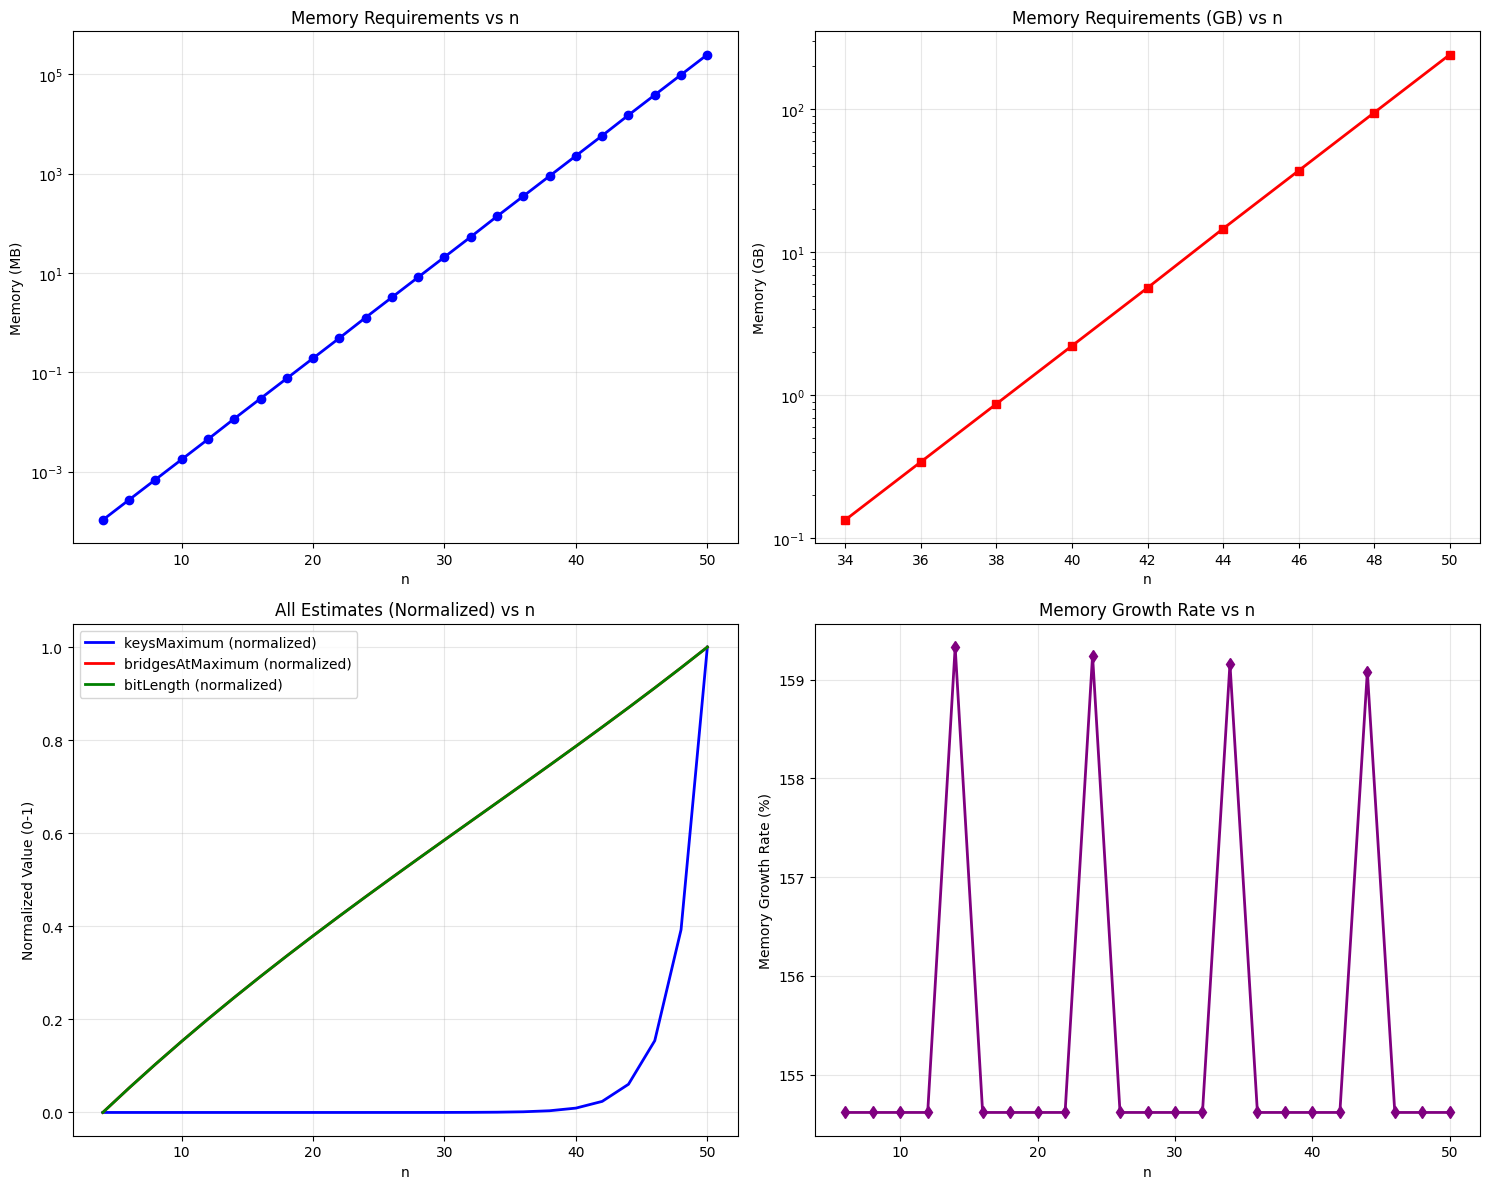


=== Final Estimation Functions ===
1. keysMaximum(n): exponential model with R² = 0.999852
2. bridgesAtMaximum(n): polynomial model with R² = 0.994338
3. bitLength(n): polynomial model with R² = 0.994338

=== Memory Thresholds ===
First n value requiring ~100MB: n = 34
First n value requiring ~1GB: n = 40
First n value requiring ~10GB: n = 44

Memory estimates saved to 'memory_estimates.csv'

=== Key Mathematical Formulas ===
keysMaximum(n) ≈ 0.319300 × 1.595669^n
bridgesAtMaximum(n) ≈ 0.393314 × n + 0.617354
bitLength(n) ≈ 0.786629 × n + 6.234708
Memory(MB) ≈ keysMaximum × (⌈bitLength/8⌉ + 52) / (1024²)

=== Specific Predictions ===
n=42: keys≈106608810, bridges≈16.9, bits≈38.7, memory≈5.659GB
n=50: keys≈4480586527, bridges≈20.0, bits≈45.0, memory≈242.027GB


In [8]:
# Define function to estimate memory requirements
def estimate_memory_requirements(n_value):
    """
    Estimate memory requirements for a given n value.
    Returns dictionary with all estimates and memory calculations.
    """
    keys_max_est = predict_keysMaximum(n_value)
    bridges_at_max_est = predict_bridgesAtMaximum(n_value)
    bit_length_est = predict_bitLength(n_value)

    # Calculate memory requirements
    # Each key requires bit_length bits
    # Python ints have overhead, so we'll estimate bytes per int
    bytes_per_key = np.ceil(bit_length_est / 8)  # Convert bits to bytes
    python_int_overhead = 28  # Python int object overhead (approximate)
    total_bytes_per_key = bytes_per_key + python_int_overhead

    # Total memory for keys only
    total_memory_keys_bytes = keys_max_est * total_bytes_per_key
    total_memory_keys_mb = total_memory_keys_bytes / (1024 * 1024)
    total_memory_keys_gb = total_memory_keys_mb / 1024

    # Dictionary overhead (hash table, pointers, etc.)
    dict_overhead_per_entry = 24  # Approximate dict entry overhead
    dict_overhead_bytes = keys_max_est * dict_overhead_per_entry
    dict_overhead_mb = dict_overhead_bytes / (1024 * 1024)

    # Total memory including dictionary overhead
    total_memory_with_overhead_bytes = total_memory_keys_bytes + dict_overhead_bytes
    total_memory_with_overhead_mb = total_memory_with_overhead_bytes / (1024 * 1024)
    total_memory_with_overhead_gb = total_memory_with_overhead_mb / 1024

    return {
        'n': n_value,
        'keysMaximum_estimated': keys_max_est,
        'bridgesAtMaximum_estimated': bridges_at_max_est,
        'bitLength_estimated': bit_length_est,
        'bytes_per_key': bytes_per_key,
        'total_bytes_per_key_with_overhead': total_bytes_per_key,
        'memory_keys_only_MB': total_memory_keys_mb,
        'memory_keys_only_GB': total_memory_keys_gb,
        'memory_with_dict_overhead_MB': total_memory_with_overhead_mb,
        'memory_with_dict_overhead_GB': total_memory_with_overhead_gb
    }

# Generate predictions for extended range
extended_n_values = list(range(4, 51, 2))  # Even values from 4 to 50
memory_estimates = [estimate_memory_requirements(n) for n in extended_n_values]
memory_df = pd.DataFrame(memory_estimates)

# Display memory estimates
print("=== Memory Requirements Estimates ===")
print(memory_df[['n', 'keysMaximum_estimated', 'bridgesAtMaximum_estimated',
                'bitLength_estimated', 'memory_with_dict_overhead_MB', 'memory_with_dict_overhead_GB']].round(2))

# Create memory visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Memory requirements (MB) vs n
axes[0, 0].plot(memory_df['n'], memory_df['memory_with_dict_overhead_MB'], 'b-', linewidth=2, marker='o')
axes[0, 0].set_xlabel('n')
axes[0, 0].set_ylabel('Memory (MB)')
axes[0, 0].set_title('Memory Requirements vs n')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Memory requirements (GB) vs n (for larger values)
large_memory_indices = memory_df['memory_with_dict_overhead_GB'] > 0.1
if large_memory_indices.any():
    axes[0, 1].plot(memory_df.loc[large_memory_indices, 'n'],
                   memory_df.loc[large_memory_indices, 'memory_with_dict_overhead_GB'],
                   'r-', linewidth=2, marker='s')
    axes[0, 1].set_xlabel('n')
    axes[0, 1].set_ylabel('Memory (GB)')
    axes[0, 1].set_title('Memory Requirements (GB) vs n')
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'No values exceed 0.1 GB\\nin current range',
                   transform=axes[0, 1].transAxes, ha='center', va='center')
    axes[0, 1].set_title('Memory Requirements (GB) vs n')

# Plot 3: All three estimates together (normalized)
# Normalize values to 0-1 scale for comparison
keys_normalized = (memory_df['keysMaximum_estimated'] - memory_df['keysMaximum_estimated'].min()) / \
                 (memory_df['keysMaximum_estimated'].max() - memory_df['keysMaximum_estimated'].min())
bridges_normalized = (memory_df['bridgesAtMaximum_estimated'] - memory_df['bridgesAtMaximum_estimated'].min()) / \
                    (memory_df['bridgesAtMaximum_estimated'].max() - memory_df['bridgesAtMaximum_estimated'].min())
bits_normalized = (memory_df['bitLength_estimated'] - memory_df['bitLength_estimated'].min()) / \
                 (memory_df['bitLength_estimated'].max() - memory_df['bitLength_estimated'].min())

axes[1, 0].plot(memory_df['n'], keys_normalized, 'b-', linewidth=2, label='keysMaximum (normalized)')
axes[1, 0].plot(memory_df['n'], bridges_normalized, 'r-', linewidth=2, label='bridgesAtMaximum (normalized)')
axes[1, 0].plot(memory_df['n'], bits_normalized, 'g-', linewidth=2, label='bitLength (normalized)')
axes[1, 0].set_xlabel('n')
axes[1, 0].set_ylabel('Normalized Value (0-1)')
axes[1, 0].set_title('All Estimates (Normalized) vs n')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Growth rates comparison
# Calculate growth rates (percentage increase from previous n)
memory_growth_rates = []
for i in range(1, len(memory_df)):
    prev_mem = memory_df.iloc[i-1]['memory_with_dict_overhead_MB']
    curr_mem = memory_df.iloc[i]['memory_with_dict_overhead_MB']
    growth_rate = ((curr_mem - prev_mem) / prev_mem) * 100 if prev_mem > 0 else 0
    memory_growth_rates.append(growth_rate)

axes[1, 1].plot(memory_df['n'][1:], memory_growth_rates, 'purple', linewidth=2, marker='d')
axes[1, 1].set_xlabel('n')
axes[1, 1].set_ylabel('Memory Growth Rate (%)')
axes[1, 1].set_title('Memory Growth Rate vs n')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary of estimation functions
print("\n=== Final Estimation Functions ===")
print(f"1. keysMaximum(n): {keysMaximum_model_type} model with R² = {r2_keys_final:.6f}")
print(f"2. bridgesAtMaximum(n): {bridgesAtMaximum_model_type} model with R² = {r2_bridges_final:.6f}")
print(f"3. bitLength(n): {bitLength_model_type} model with R² = {r2_bits_final:.6f}")

# Find critical memory thresholds
print("\n=== Memory Thresholds ===")
mb_100_index = memory_df['memory_with_dict_overhead_MB'] >= 100
gb_1_index = memory_df['memory_with_dict_overhead_GB'] >= 1
gb_10_index = memory_df['memory_with_dict_overhead_GB'] >= 10

if mb_100_index.any():
    first_100mb = memory_df.loc[mb_100_index, 'n'].iloc[0]
    print(f"First n value requiring ~100MB: n = {first_100mb}")

if gb_1_index.any():
    first_1gb = memory_df.loc[gb_1_index, 'n'].iloc[0]
    print(f"First n value requiring ~1GB: n = {first_1gb}")

if gb_10_index.any():
    first_10gb = memory_df.loc[gb_10_index, 'n'].iloc[0]
    print(f"First n value requiring ~10GB: n = {first_10gb}")

# Save results
memory_df.to_csv('c:/apps/mapFolding/memory_estimates.csv', index=False)
print("\nMemory estimates saved to 'memory_estimates.csv'")

# Print key mathematical formulas
print("\n=== Key Mathematical Formulas ===")
if keysMaximum_model_type == 'exponential':
    print(f"keysMaximum(n) ≈ {popt_exp[0]:.6f} × {popt_exp[1]:.6f}^n")
print(f"bridgesAtMaximum(n) ≈ {linear_model.coef_[0]:.6f} × n + {linear_model.intercept_:.6f}")
print(f"bitLength(n) ≈ {linear_bits_model.coef_[0]:.6f} × n + {linear_bits_model.intercept_:.6f}")
print(f"Memory(MB) ≈ keysMaximum × (⌈bitLength/8⌉ + 52) / (1024²)")

# Show specific predictions for key values
print("\n=== Specific Predictions ===")
for n_val in [42, 50, 60]:
    if n_val <= 50:
        est = estimate_memory_requirements(n_val)
        print(f"n={n_val}: keys≈{est['keysMaximum_estimated']:.0f}, bridges≈{est['bridgesAtMaximum_estimated']:.1f}, bits≈{est['bitLength_estimated']:.1f}, memory≈{est['memory_with_dict_overhead_GB']:.3f}GB")

Actual values, n = 42

keysMaximum=107506889

bridgesAtMaximum=17

curveMaximum[bridgesAtMaximum].bit_length()=39
